Set Working Directory

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research/v2'

Packages

In [2]:
import yaml, torch
import numpy as np

import src.experiments.file_io as file_io
import src.experiments.aggregate_average as core
import src.experiments.shared as shared
import src.viz.aggregate_average as viz

from pathlib import Path
from datetime import datetime

from src.utils.reproducibility import set_global_seed
from src.utils.metadata import get_git_commit_hash
from src.utils.config_loading import load_yaml_config

Functions

In [3]:
def compute_score_pair_errors(gt_score_pairs, pred_score_pairs):
    # calculate mean absolute error
    mean_error = np.mean(np.abs(gt_score_pairs - pred_score_pairs))

    # calculate ground truth std
    ground_truth_std = np.std(gt_score_pairs, ddof=1)
    
    return mean_error, ground_truth_std

In [4]:
def evaluate_error_by_missing_count(test_x, test_y, test_predictions, dims=14):
    _, cur_score = core.split_encoding_and_scores(test_x, dims=dims)
    future_score_gt = test_y

    mean_errors_list = []
    ground_truth_std_list = []
    ground_truth_dict = {}
    missing_counts = list(range(0, dims))

    for n in missing_counts:
        filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
        filtered_gt = future_score_gt[filter_mask]
        filtered_pred = test_predictions[filter_mask]

        ground_truth_dict[str(n)] = filtered_gt

        if filtered_gt.size == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
        mean_errors_list.append(mean_error)
        ground_truth_std_list.append(std_dev)

    return missing_counts, mean_errors_list, ground_truth_std_list, ground_truth_dict

Script

In [5]:
config_path = "config/experiments/20250624_aggavg_1.yaml"

In [6]:
# load configuration
config = load_yaml_config(config_path)
run_type = config["settings"]["type"] # repeat vs non-repeat
device = config["settings"]["device"] # cpu or cuda
seed = config["settings"]["seed"]

data_source = config["data"]["data_source"] # npz file with multiple arrays
model_source = config["data"]["model_source"] # path to the model
output_destination = config["data"]["destination_base"]

In [7]:
## general setup
figure_names = ["accuracy_assessment.png", "aggregate_average.png"]


## set global seed
set_global_seed(seed)

## get git commit hash
git_commit_hash = get_git_commit_hash()

In [8]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)
    
model = NN()
model = torch.load("old_data/model.pt", map_location=torch.device('cpu'))


/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_69155/3487135197.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("old_data/model.pt", map_

In [9]:
## load model
# model = shared.load_model(model_source, device=device)

In [10]:
## read data
test_data = np.load("old_data/next_step_test_data_encoded.npy")
test_data = core.filter_rows_by_sum(test_data, slice(0, 14), 1)
from src.training.training_torch import split_input_target

test_x, test_y = split_input_target(test_data)
test_predictions = shared.inference(model, test_x)
test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()

In [11]:
test_x.shape, test_y.shape, test_predictions.shape

((960116, 42), (960116, 14), (960116, 14))

In [12]:
## filter by session type
repeat_mask = core.assign_repeat(test_x)

In [13]:
repeat_mask.sum()

np.int64(956635)

In [14]:
# if run type is repeat, filter for only repeat sessions
# if run type is non-repeat, filter for only non-repeat sessions
if run_type == "repeat":
    test_x = test_x[repeat_mask]
    test_y = test_y[repeat_mask]
    test_predictions = test_predictions[repeat_mask]
elif run_type == "non-repeat":
    test_x = test_x[~repeat_mask]
    test_y = test_y[~repeat_mask]
    test_predictions = test_predictions[~repeat_mask]

In [15]:
test_x.shape, test_y.shape, test_predictions.shape

((3481, 42), (3481, 14), (3481, 14))

(1) find ground truth std and prediction MAE

In [16]:
encoding, cur_score = core.split_encoding_and_scores(test_x, dims=14)
future_score_gt = test_y

mean_errors_list = []
ground_truth_std_list = []
ground_truth_dict = {}
missing_counts = list(range(0, 14))

In [17]:
for n in missing_counts:
    filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
    filtered_encoding = encoding[filter_mask]
    filtered_gt = future_score_gt[filter_mask][filtered_encoding == 1]
    filtered_pred = test_predictions[filter_mask][filtered_encoding == 1]

    ground_truth_dict[str(n)] = filtered_gt

    if filtered_gt.size == 0:
        mean_errors_list.append(np.nan)
        ground_truth_std_list.append(np.nan)
        continue

    mean_error, std_dev = core.compute_errors(filtered_gt, filtered_pred)
    mean_errors_list.append(mean_error)
    ground_truth_std_list.append(std_dev)

[0.2876104  0.4296505  0.4011687  0.0851903  0.27029562]
[0.1622284  0.19464827 0.00518    0.04114538 0.12566778]
[0.18198514 0.3717196  0.38233447 0.2432714  0.42046225]
[0.20461869 0.28964305 0.367172   0.4455082  0.04894078]
[0.20616391 0.04379207 0.34926343 0.34065694 0.44645172]
[0.14445072 0.13663709 0.3495512  0.21210241 0.17301062]
[0.25062668 0.35571563 0.31752878 0.04667783 0.03059959]
[0.25655875 0.31509745 0.15398023 0.16313604 0.53030574]
[0.1634582  0.26381752 0.28953132 0.47590062 0.23813102]
[0.24042368 0.2901     0.46093768 0.32261053 0.01683867]
[0.00937435 0.13366714 0.1657826  0.0588358  0.21588168]
[0.1737738  0.36086518 0.19368663 0.31050175 0.02932262]
[0.02686641 0.2653308  0.396949   0.3271251  0.19749919]


In [40]:
mean_errors_list

[nan,
 np.float32(0.28071186),
 np.float32(0.27214304),
 np.float32(0.26534933),
 np.float32(0.25225565),
 np.float32(0.25999567),
 np.float32(0.2471299),
 np.float32(0.2688843),
 np.float32(0.23980716),
 np.float32(0.24648431),
 np.float32(0.25723904),
 np.float32(0.23371357),
 np.float32(0.22580345),
 np.float32(0.3227173)]

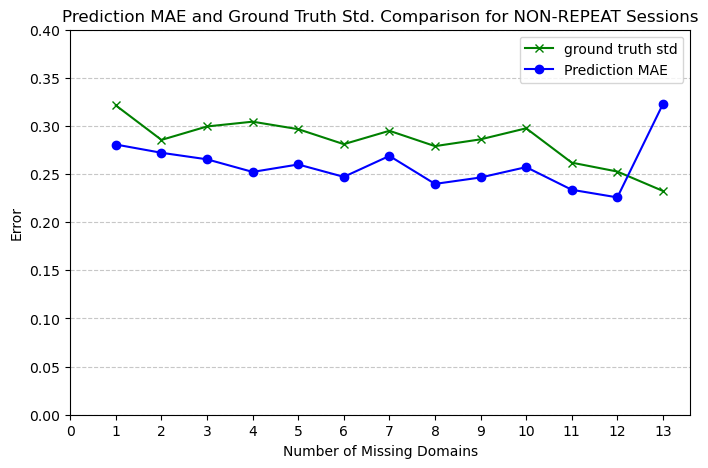

In [20]:
# plot error by missing count and save figure
viz.plot_error_by_missing_count(
    x_axis=missing_counts,
    std=ground_truth_std_list,
    error=mean_errors_list,
    run_type=run_type
)

(2) predict scores based on strategy

In [21]:
# ground truth original scores
encoding, scores_gt = core.split_encoding_and_scores(test_x, dims=14)

In [22]:
# ground truth future scores
future_scores_gt = test_y

In [23]:
scores_gt.shape, future_scores_gt.shape

((3481, 28), (3481, 14))

In [24]:
scores_gt[:3]

array([[0.        , 0.        , 0.363     , 0.63699996, 0.345     ,
        0.655     , 0.413     , 0.587     , 0.205     , 0.795     ,
        0.        , 0.        , 0.056     , 0.944     , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 0.279     ,
        0.72099996, 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.467     ,
        0.533     , 0.214     , 0.786     , 0.05      , 0.95      ,
        0.684     , 0.31599998, 0.        , 0.        , 0.        ,
        1.        , 0.25      , 0.75      , 0.286     , 0.714     ,
        1.        , 1.        , 0.        , 0.        , 0.455     ,
        0.54499996, 0.        , 0.        ],
       [0.632     , 0.36799997, 0.36      , 0.64      , 1.        ,
        0.        , 1.        , 0.        , 0.361     , 0.639     ,
        0.667     , 0.333     , 0.        , 0.        , 0.333     ,
        0.667     , 0.16  

In [25]:
future_scores_gt[:3]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.185, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.7  ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.278, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [26]:
# best
prediction_list = []
rows, cols = test_y.shape
_, scores = core.split_encoding_and_scores(test_x, dims=14)
for domain in missing_counts:
    single_encoding = core.create_single_encoding(rows, cols, domain)
    tmp_single = core.add_encoding(scores, single_encoding)
    single_prediction = shared.inference(model, tmp_single)
    prediction_list.append(single_prediction[:, domain])

prediction_matrix = np.column_stack(prediction_list)
difference = prediction_matrix - scores[:, ::2]

# find max indices
max_values, max_indices = shared.max_prediction_from_difference_pair(difference, prediction_matrix, scores, run_type)
# reconstruct matrices
future_scores_best, best_encoding = core.reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

In [27]:
# random
random_encoding, future_scores_random = core.find_random_predictions(
    model=model,
    data=scores_gt,
    run_type=run_type
)

In [28]:
average_gt_list = []
average_best_list = []
average_random_list = []

std_gt_list = []
std_best_list = []
std_random_list = []

In [29]:
def compute_averages_and_stds(cur_scores, future_scores, masks):
    """
    masks: first mask for missing count, second mask for location of target value (encoding == 1)
    """
    difference = future_scores - cur_scores
    difference_filtered = core.filter_with_masks(difference, masks)

    average = np.mean(difference_filtered)
    std_dev = np.std(difference_filtered)

    return average, std_dev

In [30]:
# for n in missing_counts:
#     # get missing mask
#     missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
#     # get original data that fit the missing count
#     # call helper calculate ground truth
#     compute_averages_and_stds(scores_gt, future_scores_gt, missing_mask)
#     # call helper find random predictions and encoding
#     future_scores_random = core.find_random_predictions(
#         model=model,
#         data=test_x,
#         run_type=run_type
#     )
#     # call helper calculate
#     compute_averages_and_stds(scores_gt, future_scores_random, missing_mask)
#     # call helper find best predictions and encoding
#     future_scores_best, best_encoding = core.find_best_predictions(
#         model=model,
#         data=test_x,
#         run_type=run_type
#     )
#     # call helper calculate
#     pass

In [31]:
for n in missing_counts:
    missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
    
    scores_gt_tmp = scores_gt[missing_mask][:, ::2]

    future_scores_gt_tmp = future_scores_gt[missing_mask]
    future_scores_best_tmp = future_scores_best[missing_mask]
    future_scores_random_tmp = future_scores_random[missing_mask]

    difference_gt = future_scores_gt_tmp - scores_gt_tmp
    difference_gt = difference_gt[encoding[missing_mask] == 1]
    difference_best = future_scores_best_tmp - scores_gt_tmp
    difference_best = difference_best[best_encoding[missing_mask] == 1]
    difference_random = future_scores_random_tmp - scores_gt_tmp
    difference_random = difference_random[random_encoding[missing_mask] == 1]

    average_gt = np.mean(difference_gt)
    average_best = np.mean(difference_best)
    average_random = np.mean(difference_random)

    std_gt = np.std(difference_gt)
    std_best = np.std(difference_best)
    std_random = np.std(difference_random)

    average_gt_list.append(average_gt)
    average_best_list.append(average_best)
    average_random_list.append(average_random)

    std_gt_list.append(std_gt)
    std_best_list.append(std_best)
    std_random_list.append(std_random)

/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/CT/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: inval

In [32]:
random_encoding[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [33]:
test_x[0, 14:]

array([0.        , 0.        , 0.363     , 0.63699996, 0.345     ,
       0.655     , 0.413     , 0.587     , 0.205     , 0.795     ,
       0.        , 0.        , 0.056     , 0.944     , 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.279     ,
       0.72099996, 1.        , 1.        ], dtype=float32)

In [34]:
test_y[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.185, 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [35]:
test_x[missing_mask]

array([[1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(238, 42), dtype=float32)

In [36]:
average_best_list

[np.float64(nan),
 np.float64(-0.014630029391911294),
 np.float64(0.3015922943665746),
 np.float64(0.45101285777685846),
 np.float64(0.4646792173549369),
 np.float64(0.5020981267237434),
 np.float64(0.5436452847976622),
 np.float64(0.5715733372530684),
 np.float64(0.5969055678163256),
 np.float64(0.615938292145729),
 np.float64(0.624950262658093),
 np.float64(0.6580278628870196),
 np.float64(0.630164813875352),
 np.float64(0.6761806048139805)]

In [37]:
import matplotlib.pyplot as plt

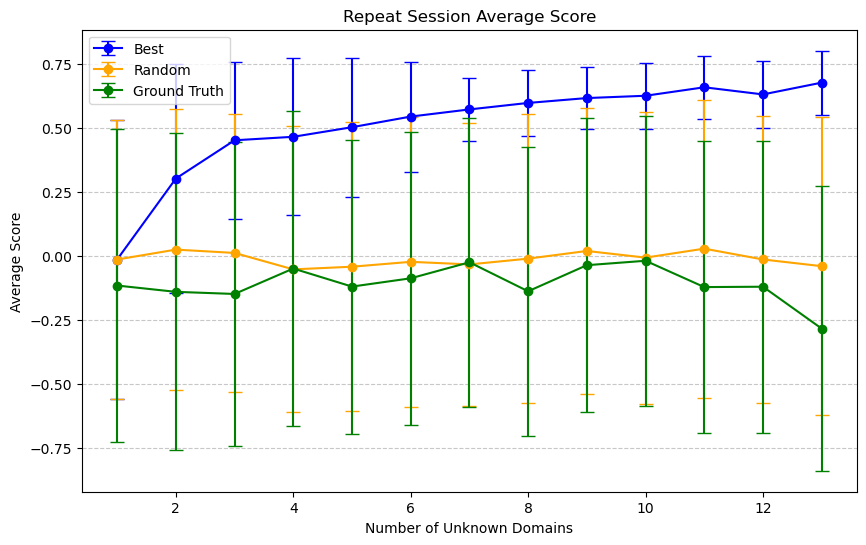

In [38]:
# Define x-axis values (number of unknown domains)
# Plot with error bars


In [39]:
'''# get score pairs
gt_score_pairs = core.extract_score_pairs(gt_score_pairs)
pred_score_pairs = core.extract_score_pairs(pred_score_pairs)

# find valid score pairs
valid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])

# filter valid score pairs
gt_score_pairs = gt_score_pairs[valid_mask]
pred_score_pairs = pred_score_pairs[valid_mask]'''



'# get score pairs\ngt_score_pairs = core.extract_score_pairs(gt_score_pairs)\npred_score_pairs = core.extract_score_pairs(pred_score_pairs)\n\n# find valid score pairs\nvalid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])\n\n# filter valid score pairs\ngt_score_pairs = gt_score_pairs[valid_mask]\npred_score_pairs = pred_score_pairs[valid_mask]'